In [4]:
# Clean Notebook
!rm -r *.7z *.py ./trainHelper ./dataset ./plotter ./helper *.txt

rm: cannot remove '*.txt': No such file or directory


In [ ]:
# Unzip
!unzip code.zip
!rm code.zip

In [ ]:
!pip install -r requirements.txt

** USING CUDA **
--- Data Preparation ---
--- Prepared Data ---
--- Initial Testing ---

Testing Results
--------------------------------------------------
AUROC:          0.5268
AUPRC:          0.5253
F1 Score:       0.6500
Loss:           0.7035
Time:           11:28:13

--- Go for Training ---

***** Running Epoch : 1 *****

Training at Epoch 1 iteration 0 with loss 0.7013323903083801
Training at Epoch 1 iteration 200 with loss 0.44639331102371216
Training at Epoch 1 iteration 400 with loss 0.533327579498291
Training at Epoch 1 iteration 600 with loss 0.5464850664138794
Training at Epoch 1 iteration 800 with loss 0.7383765578269958
Training at Epoch 1 iteration 1000 with loss 0.6766918301582336
Training at Epoch 1 iteration 1200 with loss 0.6199190616607666
Training at Epoch 1 iteration 1400 with loss 0.5240082740783691
Training at Epoch 1 iteration 1600 with loss 0.40739449858665466
Training at Epoch 1 iteration 1800 with loss 0.49866023659706116

Model Training Summary:
----------

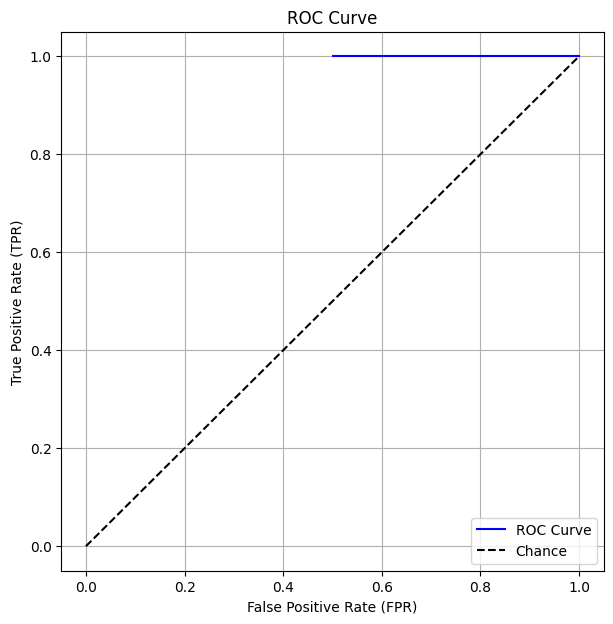

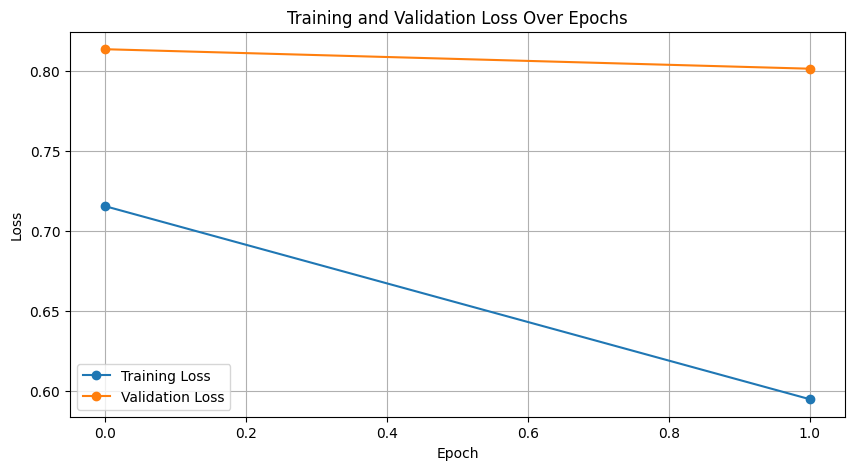

In [3]:
import copy
import json
import os
from time import time

import argparse

import numpy as np
import pandas as pd
import torch
import warnings
from torch.utils import data
from torch import nn

from plotter.plot_auc import make_auc_auprc
from plotter.plot_confusionMatrix import make_confusion_matrix_grid
from plotter.plot_loss import make_loss_plots
from plotter.plot_roc import make_roc
from trainHelper.metricTracker import display_validation_metrics, update_metrics_history, get_metrics_summary, \
     display_testing_metrics, display_metrics_summary
from trainHelper.lossTracker import get_model_loss_summary
from trainHelper.test import test


torch.manual_seed(2)  # reproducible torch:2 np:3
np.random.seed(3)
from argparse import ArgumentParser
from config import BIN_config_DBPE
from models import BIN_Interaction_Flat
from stream import BIN_Data_Encoder

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"** USING {device.type.upper()} **")

parser = ArgumentParser(description="MolTrans Training.")
parser.add_argument(
    "-b",
    "--batch-size",
    default=16,
    type=int,
    metavar="N",
    help="mini-batch size (default: 16), this is the total "
         "batch size of all GPUs on the current node when "
         "using Data Parallel or Distributed Data Parallel",
)
parser.add_argument(
    "-j",
    "--workers",
    default=0,
    type=int,
    metavar="N",
    help="number of data loading workers (default: 0)",
)
parser.add_argument(
    "--epochs", default=30, type=int, metavar="N", help="number of total epochs to run"
)
parser.add_argument(
    "--task",
    choices=["biosnap", "bindingdb", "davis"],
    default="",
    type=str,
    metavar="TASK",
    help="Task name. Could be biosnap, bindingdb and davis.",
)
parser.add_argument(
    "--lr",
    "--learning-rate",
    default=1e-4,
    type=float,
    metavar="LR",
    help="initial learning rate",
    dest="lr",
)

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

DRIVE_PATH = "/content/drive/MyDrive/DL_Model"

training_loss_dict = {}
validation_loss_dict = {}

confusion_matrices = []
metrics_history = []

def get_task(task_name):
    if task_name.lower() == "biosnap":
        return "./dataset/BIOSNAP/full_data"
    elif task_name.lower() == "bindingdb":
        return "./dataset/BindingDB"
    elif task_name.lower() == "davis":
        return "./dataset/DAVIS"


def prepare_data(args):
    print("--- Data Preparation ---")
    params = {
        "batch_size": args.batch_size,
        "shuffle": True,
        "num_workers": args.workers,
        "drop_last": True,
    }
    dataFolder = get_task(args.task)
    df_train = pd.read_csv(dataFolder + "/train.csv")
    df_val = pd.read_csv(dataFolder + "/val.csv")
    df_test = pd.read_csv(dataFolder + "/test.csv")
    training_set = BIN_Data_Encoder(
        df_train.index.values, df_train.Label.values, df_train
    )
    training_generator = data.DataLoader(training_set, **params)

    validation_set = BIN_Data_Encoder(
        df_val.index.values, df_val.Label.values, df_val
    )
    validation_generator = data.DataLoader(validation_set, **params)

    testing_set = BIN_Data_Encoder(df_test.index.values, df_test.Label.values, df_test)
    testing_generator = data.DataLoader(testing_set, **params)

    print("--- Prepared Data ---")

    return testing_generator, training_generator, validation_generator


def main():
    global metrics_history, training_loss_dict, validation_loss_dict, confusion_matrices

    config = BIN_config_DBPE()
    args = argparse.Namespace(batch_size=10, workers=0, epochs=30, task='biosnap', lr=0.0001)
    config["batch_size"] = args.batch_size

    loss_history = []

    model = BIN_Interaction_Flat(**config)
    model = model.to(device)

    if device.type == "cuda" and torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model, dim=0)

    opt = torch.optim.Adam(model.parameters(), lr=args.lr)
    loss_fct = torch.nn.BCELoss()

    testing_generator, training_generator, validation_generator = prepare_data(args)

    # early stopping
    model_max = copy.deepcopy(model)

    print("--- Initial Testing ---")
    with torch.set_grad_enabled(False):
        auc, auprc, f1, logits, loss, confusion_matrix = test(testing_generator, model_max)
        display_testing_metrics(auc, auprc, f1, loss)

    print("--- Go for Training ---")
    torch.backends.cudnn.benchmark = True
    for epo in range(args.epochs):
        print(f"\n{'*'*5} Running Epoch : {epo+1} {'*'*5}\n")
        model.train()

        for i, (d, p, d_mask, p_mask, label) in enumerate(training_generator):
            # Move all tensors to the same device
            d = d.long().to(device)
            p = p.long().to(device)
            d_mask = d_mask.long().to(device)
            p_mask = p_mask.long().to(device)
            label = torch.tensor(label, dtype=torch.float).to(device)

            score = model(d, p, d_mask, p_mask)

            m = torch.nn.Sigmoid()
            n = torch.squeeze(m(score))

            loss = loss_fct(n, label)
            loss_history.append(loss.item())

            opt.zero_grad()
            loss.backward()
            opt.step()

            if i % 200 == 0:
                print(
                    "Training at Epoch "
                    + str(epo + 1)
                    + " iteration "
                    + str(i)
                    + " with loss "
                    + str(loss.item())
                )

        training_loss_dict[epo] = float(loss.item())
        print(get_model_loss_summary(loss_history))

        # every epoch test
        with torch.set_grad_enabled(False):
            auc, auprc, f1, logits, loss, confusion_matrix = test(validation_generator, model)

            validation_loss_dict[epo] = loss

            confusion_matrices.append(confusion_matrix)

            # Display current metrics
            display_validation_metrics(epo + 1, auc, auprc, f1, loss)

            # Update history and check if best model
            metrics_history, is_best = update_metrics_history(
                metrics_history, epo + 1, auc, auprc, f1, loss
            )

            if is_best:
                torch.save(model.state_dict(), f'{DRIVE_PATH}/best_model')
                model_max = copy.deepcopy(model)

    try:
        with torch.set_grad_enabled(False):
            auc, auprc, f1, logits, loss, confusion_matrix = test(testing_generator, model_max)
            display_testing_metrics(auc, auprc, f1, loss)
    except:
        print("testing failed")
    return model_max, loss_history


s = time()
model_max, loss_history = main()
e = time()

print("Time Take: ",  e - s)
display_metrics_summary(get_metrics_summary(metrics_history))

with open(f"{DRIVE_PATH}/output/train_loss.json", "w") as f:
    f.write(json.dumps(training_loss_dict, indent=4))

with open(f"{DRIVE_PATH}/output/val_loss.json", "w") as f:
    f.write(json.dumps(validation_loss_dict, indent=4))

with open(f"{DRIVE_PATH}/output/metric_history.json", "w") as f:
    f.write(json.dumps(metrics_history, indent=4))


np.save(f"{DRIVE_PATH}/output/conf_mat", np.array(confusion_matrices))

make_roc()
make_auc_auprc()
make_loss_plots()
make_confusion_matrix_grid()

In [4]:
!zip -r output.zip output

  adding: output/ (stored 0%)
  adding: output/metric_history.json (deflated 63%)
  adding: output/train_loss.json (deflated 13%)
  adding: output/conf_mat.npy (deflated 57%)
  adding: output/val_loss.json (deflated 15%)
  adding: output/figs/ (stored 0%)
  adding: output/figs/auc_auprc_plot.png (deflated 17%)
  adding: output/figs/confusion_matrix_grid.png (deflated 37%)
  adding: output/figs/roc_plot.png (deflated 25%)
  adding: output/figs/training_validation_loss_plot.png (deflated 23%)
